Moran's I: 0.21825270169813019, p-value: 0.001


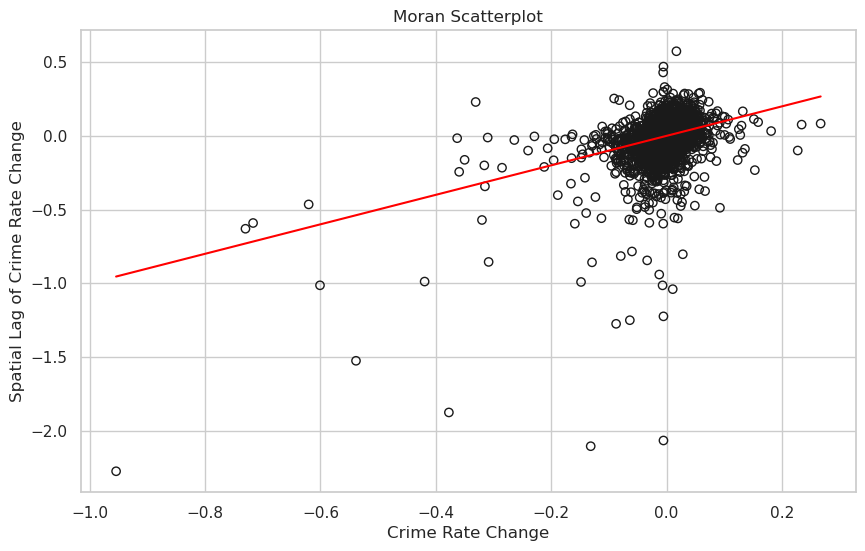

In [13]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
from libpysal.weights import lag_spatial
from esda import Moran
import matplotlib.pyplot as plt
from libpysal.weights import KNN

# 读取数据
data = pd.read_csv('analysis_data/Moran.csv')  # 读取你的数据文件

# 用均值填补空值
data['crime_rate_change'].fillna(data['crime_rate_change'].mean(), inplace=True)
data['gentrification_score'].fillna(data['gentrification_score'].mean(), inplace=True)

data['geometry'] = data['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(data, geometry='geometry')

# 使用K近邻权重矩阵，k=6表示每个区域至少有6个邻居
w = KNN.from_dataframe(gdf, k=6)

# 绅士化得分和犯罪率变化的空间自相关分析
gdf['crime_rate_change_lag'] = lag_spatial(w, gdf['crime_rate_change'])
mi = Moran(gdf['crime_rate_change'], w)

# 打印莫兰指数和p值
print(f"Moran's I: {mi.I}, p-value: {mi.p_sim}")

# 可视化莫兰散点图
fig, ax = plt.subplots(1, figsize=(10, 6))
plt.scatter(gdf['crime_rate_change'], gdf['crime_rate_change_lag'], edgecolor='k', facecolor='none')
plt.plot([gdf['crime_rate_change'].min(), gdf['crime_rate_change'].max()],
         [gdf['crime_rate_change'].min(), gdf['crime_rate_change'].max()], color='red')
plt.title("Moran Scatterplot")
plt.xlabel("Crime Rate Change")
plt.ylabel("Spatial Lag of Crime Rate Change")
plt.grid(True)
plt.show()




In [11]:
import numpy as np
from libpysal.weights import KNN
from spreg import ML_Lag, ML_Error
from scipy.stats import t

# 使用 K 近邻权重矩阵，k=6 表示每个区域至少有 6 个邻居
w = KNN.from_dataframe(gdf, k=6)

# 自变量和因变量
y = gdf['crime_rate_change'].values
X = gdf['gentrification_score'].values.reshape(-1, 1)

# 空间误差模型（SEM）
try:
    error_model = ML_Error(y, X, w)

    # 提取回归系数和标准误差
    betas = error_model.betas.flatten()
    print(f"Betas: {betas}")
    print(f"Shape of Betas: {betas.shape}")

    # 检查输出的其他部分
    if hasattr(error_model, 'vm'):
        standard_errors = np.sqrt(np.diag(error_model.vm))
        print(f"Standard Errors: {standard_errors}")
        print(f"Shape of Standard Errors: {standard_errors.shape}")

        # 计算 t 值
        t_values = betas / standard_errors
        print(f"t-values: {t_values}")

        # 计算 p 值
        p_values = [2 * (1 - t.cdf(np.abs(t_value), df=len(gdf) - len(betas))) for t_value in t_values]
        print(f'p-values: {p_values}')
    
        # 打印结果
        print('Spatial Error Model (SEM)')
        print(f'Coefficients: {betas}')
        print(f'Standard Errors: {standard_errors}')
        print(f't-values: {t_values}')
        print(f'p-values: {p_values}')
        print(f'R-squared: {error_model.pr2}')
    else:
        print("Warning: error_model does not have attribute 'vm'.")
except Exception as e:
    print(f"An error occurred: {e}")


/opt/conda/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/opt/conda/lib/python3.11/site-packages/spreg/ml_error.py:531: RuntimeWarning: divide by zero encountered in log
  jacob = np.log(np.linalg.det(a))
/opt/conda/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2306: RuntimeWarning: invalid value encountered in scalar multiply
  q = (xf - fulc) * (fx - fnfc)
/opt/conda/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r


Betas: [-0.00625672  0.00044351  0.08448125]
Shape of Betas: (3,)
Standard Errors: [0.00111797 0.0005561  0.00301926]
Shape of Standard Errors: (3,)
t-values: [-5.59650411  0.79753709 27.98073278]
p-values: [2.3080475086700858e-08, 0.42517840604379176, 0.0]
Spatial Error Model (SEM)
Coefficients: [-0.00625672  0.00044351  0.08448125]
Standard Errors: [0.00111797 0.0005561  0.00301926]
t-values: [-5.59650411  0.79753709 27.98073278]
p-values: [2.3080475086700858e-08, 0.42517840604379176, 0.0]
R-squared: 6.409263133446615e-05


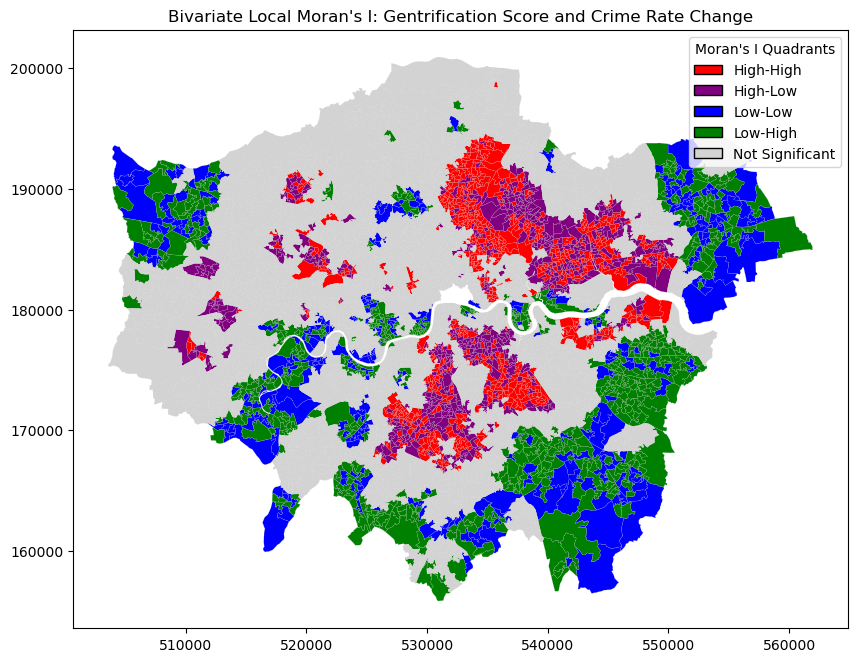

In [8]:
import libpysal
import esda
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

# 创建K近邻权重矩阵
w = libpysal.weights.KNN.from_dataframe(gdf, k=6)
w.transform = 'r'

# 定义自变量和因变量
y = gdf['crime_rate_change'].values
x = gdf['gentrification_score'].values

# 计算自变量的滞后值
lag_x = libpysal.weights.lag_spatial(w, x)

# 计算局部双变量莫兰指数
bivar_moran = esda.Moran_Local_BV(y, lag_x, w)

# 创建一个新的列来保存象限信息
gdf['quadrant'] = bivar_moran.q
# 创建一个列来保存p值信息
gdf['p_value'] = bivar_moran.p_sim

# 设定显著性水平，例如0.05
significance_level = 0.05

# 设置自定义颜色映射
cmap = ListedColormap(['red', 'purple', 'blue', 'green', 'lightgray'])
# 创建一个字典来映射象限编号到标签
labels = {1: 'High-High', 2: 'High-Low', 3: 'Low-Low', 4: 'Low-High'}

# 绘制局部双变量莫兰指数的象限图
fig, ax = plt.subplots(1, figsize=(10, 8))

# 过滤显著区域，并绘制每个象限的图层
for quadrant, color in zip([1, 2, 3, 4], cmap.colors):
    subset = gdf[(gdf['quadrant'] == quadrant) & (gdf['p_value'] <= significance_level)]
    subset.plot(color=color, linewidth=0.1, ax=ax, edgecolor='0.8')

# 绘制不显著区域
nonsignificant = gdf[gdf['p_value'] > significance_level]
nonsignificant.plot(color='lightgray', linewidth=0.1, ax=ax, edgecolor='0.8', label='Not Significant')

# 自定义图例
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='High-High'),
    Patch(facecolor='purple', edgecolor='black', label='High-Low'),
    Patch(facecolor='blue', edgecolor='black', label='Low-Low'),
    Patch(facecolor='green', edgecolor='black', label='Low-High'),
    Patch(facecolor='lightgray', edgecolor='black', label='Not Significant')
]

# 添加图例到绘图中
ax.legend(handles=legend_elements, title="Moran's I Quadrants")

plt.title('Bivariate Local Moran\'s I: Gentrification Score and Crime Rate Change')
plt.show()


/tmp/ipykernel_21455/1496922362.py:23: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  highlight.plot(ax=ax, color='green', edgecolor='black', alpha=0.5)


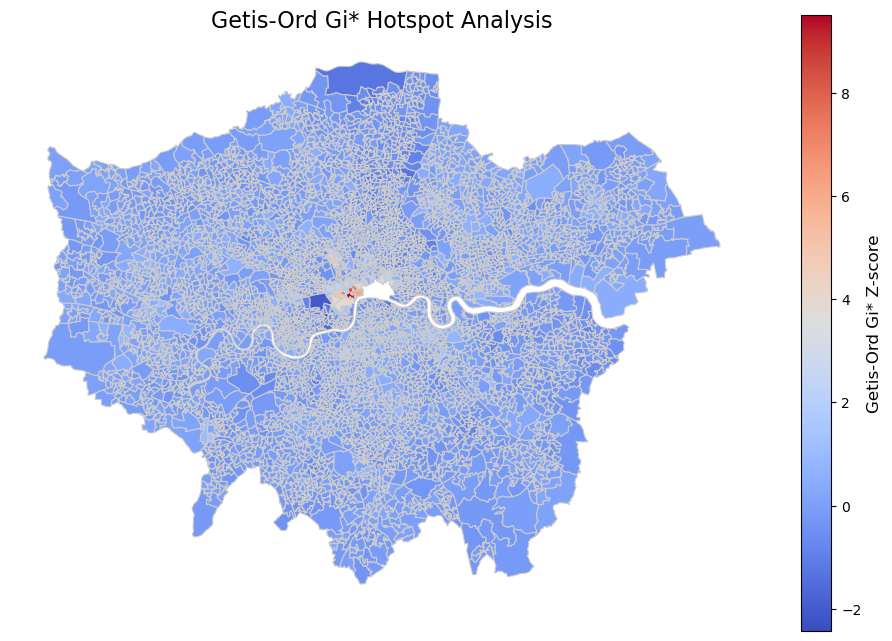

In [4]:
from esda.getisord import G_Local
from matplotlib.colors import Normalize
import matplotlib.colorbar as colorbar
import matplotlib.pyplot as plt

# Calculate Getis-Ord Gi* statistic
g_local = G_Local(gdf['crime_rate_change'], w)

# Add the Getis-Ord Gi* statistic and z-scores to the GeoDataFrame
gdf['g_star'] = g_local.Zs

# Plot Getis-Ord Gi* statistic results
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Normalize for better color representation
norm = Normalize(vmin=gdf['g_star'].min(), vmax=gdf['g_star'].max())

# Plot the entire GeoDataFrame with Getis-Ord Gi* results
gdf.plot(column='g_star', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', norm=norm)

# Highlight the areas with LAD11CD == 'E09000001'
highlight = gdf[gdf['LAD11CD'] == 'E09000001']
highlight.plot(ax=ax, color='green', edgecolor='black', alpha=0.5)

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Getis-Ord Gi* Z-score", fontsize=12)

ax.set_title("Getis-Ord Gi* Hotspot Analysis", fontsize=16)
ax.set_axis_off()

plt.show()


平衡性检查结果：
ethnic_2011: t统计量 = 41.0762, p值 = 0.0000
education_2011: t统计量 = 18.3442, p值 = 0.0000
elderly_2011: t统计量 = -23.3079, p值 = 0.0000
unemployed_2011: t统计量 = 43.0735, p值 = 0.0000
median_house_price_2011: t统计量 = -24.3382, p值 = 0.0000


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32453 (\N{CJK UNIFIED IDEOGRAPH-7EC5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22763 (\N{CJK UNIFIED IDEOGRAPH-58EB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22495 (\N{CJK UNIFIED IDEOGRAPH-57DF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/

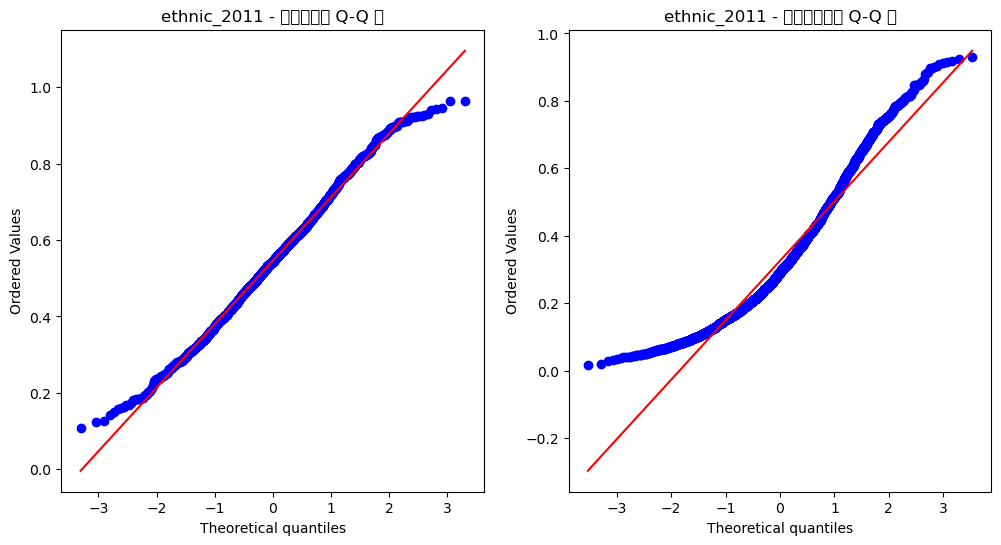

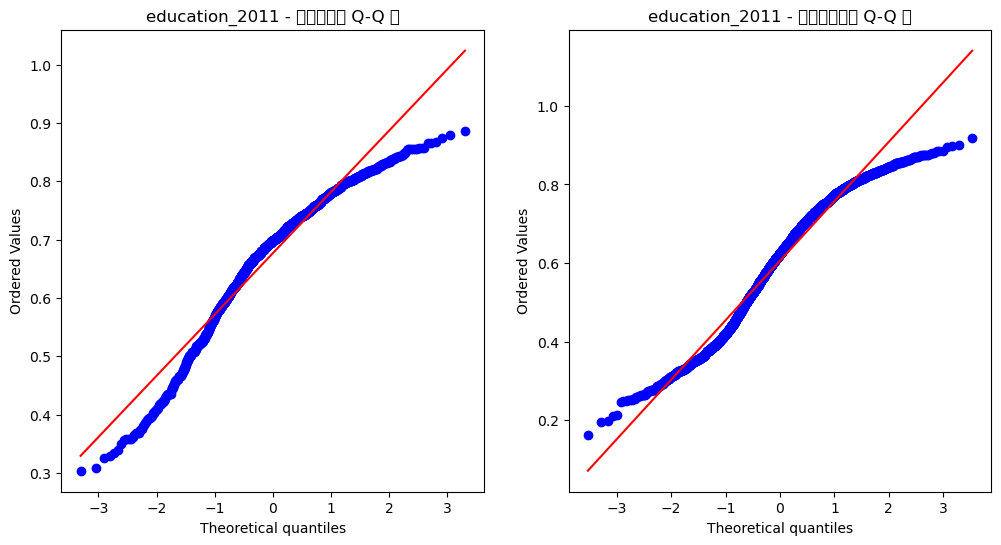

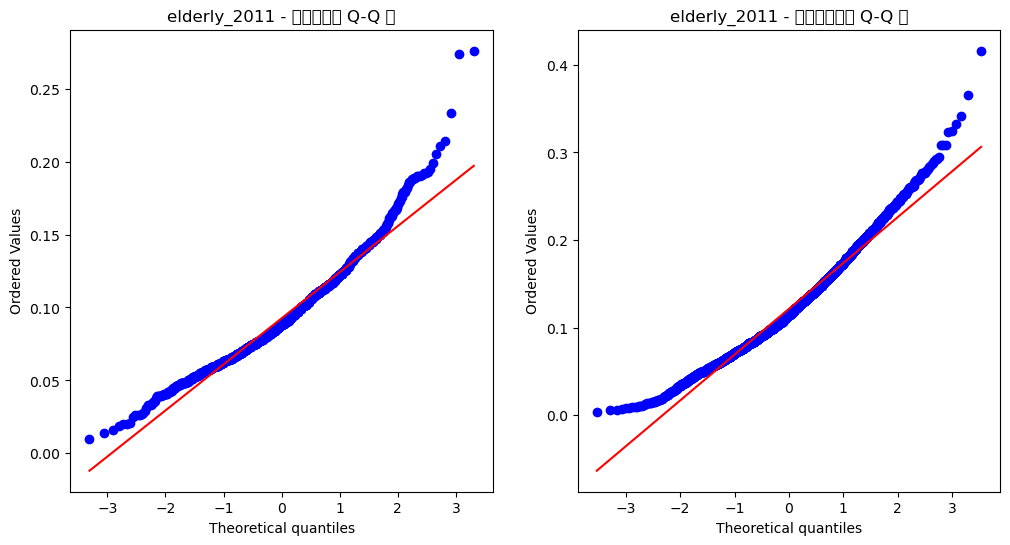

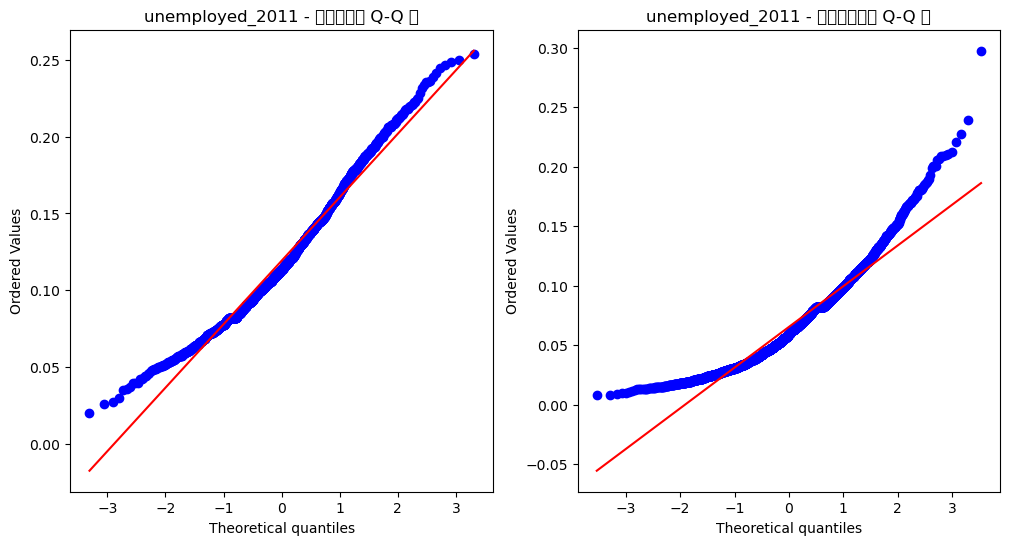

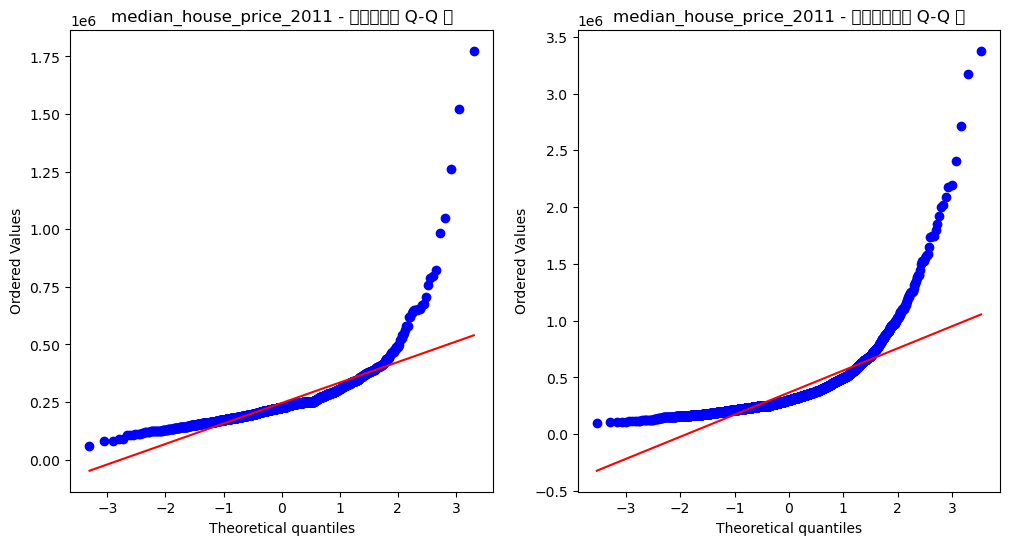


标准化均值误差 (SME) 结果：
ethnic_2011: SME = 1.2632
education_2011: SME = 0.5339
elderly_2011: SME = 0.6600
unemployed_2011: SME = 1.3895
median_house_price_2011: SME = 0.6565

平均处理效应 (ATT) 结果：
ATT (犯罪率): 0.0141

平均绅士化区域的犯罪率: 0.09089870788843539
平均未绅士化区域的犯罪率: 0.07679537291128312

t统计量: 5.922047587745812
p值: 3.4567170685691872e-09


In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_ind, probplot
import matplotlib.pyplot as plt

# 导入数据
data = pd.read_csv('analysis_data/DID.csv')

# 定义目标变量：是否发生绅士化
data['gentrified'] = (data['gentrification_score'] > 0).astype(int)

# 定义预测变量
X = data[['ethnic_2011', 'education_2011', 'elderly_2011', 'unemployed_2011', 'median_house_price_2011']]
y = data['gentrified']

# 拆分数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 建立逻辑回归模型来计算倾向得分
logit = LogisticRegression()
logit.fit(X_train, y_train)

# 计算倾向得分
data['propensity_score'] = logit.predict_proba(X)[:, 1]

# 定义匹配器
matched = NearestNeighbors(n_neighbors=1).fit(data[['propensity_score']])

# 匹配最近邻
distances, indices = matched.kneighbors(data[['propensity_score']])

# 添加匹配结果到原数据中
data['matched_area'] = data.index[indices[:, 0]]

# 获取匹配结果（去除未匹配的区域）
matched_data = data.loc[data.index.isin(data['matched_area'].values)]

# 平衡性检查
def balance_check(df, covariates, group_var):
    print("\n平衡性检查结果：")
    for covariate in covariates:
        treated = df[df[group_var] == 1][covariate]
        control = df[df[group_var] == 0][covariate]
        t_stat, p_value = ttest_ind(treated, control, equal_var=False)  # Welch’s t-test
        print(f"{covariate}: t统计量 = {t_stat:.4f}, p值 = {p_value:.4f}")

# 进行平衡性检查
covariates = ['ethnic_2011', 'education_2011', 'elderly_2011', 'unemployed_2011', 'median_house_price_2011']
balance_check(matched_data, covariates, 'gentrified')

# Q-Q 图
def qq_plot(df, covariate, group_var):
    treated = df[df[group_var] == 1][covariate]
    control = df[df[group_var] == 0][covariate]
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    probplot(treated, dist="norm", plot=axs[0])
    axs[0].set_title(f'{covariate} - 绅士化区域 Q-Q 图')
    
    probplot(control, dist="norm", plot=axs[1])
    axs[1].set_title(f'{covariate} - 未绅士化区域 Q-Q 图')
    
    plt.show()

# 绘制 Q-Q 图
for covariate in covariates:
    qq_plot(matched_data, covariate, 'gentrified')

# 计算和输出 SME
def calculate_sme(df, covariates, group_var):
    sme_results = {}
    for covariate in covariates:
        mean_treated = df[df[group_var] == 1][covariate].mean()
        mean_control = df[df[group_var] == 0][covariate].mean()
        sd_treated = df[df[group_var] == 1][covariate].std()
        sd_control = df[df[group_var] == 0][covariate].std()
        sme = abs(mean_treated - mean_control) / np.sqrt((sd_treated**2 + sd_control**2) / 2)
        sme_results[covariate] = sme
    return sme_results

# 计算 SME
sme_results = calculate_sme(matched_data, covariates, 'gentrified')
print("\n标准化均值误差 (SME) 结果：")
for covariate, sme in sme_results.items():
    print(f"{covariate}: SME = {sme:.4f}")

# 计算 ATT
def calculate_att(df, outcome_var, group_var):
    treated_outcome = df[df[group_var] == 1][outcome_var]
    control_outcome = df[df[group_var] == 0][outcome_var]
    att = treated_outcome.mean() - control_outcome.mean()
    return att

# 计算 ATT
att_crime = calculate_att(matched_data, 'crime_2021', 'gentrified')
print("\n平均处理效应 (ATT) 结果：")
print(f"ATT (犯罪率): {att_crime:.4f}")

# 按照匹配的区域对比犯罪率
gentrified_crime = matched_data.loc[matched_data['gentrified'] == 1, 'crime_2021']
non_gentrified_crime = matched_data.loc[matched_data['gentrified'] == 0, 'crime_2021']

# 比较两个组的犯罪率
average_gentrified_crime = gentrified_crime.mean()
average_non_gentrified_crime = non_gentrified_crime.mean()

print("\n平均绅士化区域的犯罪率:", average_gentrified_crime)
print("平均未绅士化区域的犯罪率:", average_non_gentrified_crime)

# 进行t检验
t_stat, p_value = ttest_ind(gentrified_crime, non_gentrified_crime, equal_var=False)  # Welch’s t-test

print("\nt统计量:", t_stat)
print("p值:", p_value)
